# Calculating MSE and saving it

In [1]:
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import time
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
from scipy.stats import linregress, pearsonr
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
from multiprocessing import Pool, cpu_count
from scipy.stats import percentileofscore


### Here is what we are going for:

$$h = c_pT + L_vq$$
cp = 1004.6
Lv = 2500000

In [1]:
## This gets the percentile of MSE in the historical simulation over land that corresponds to the mean MSE of land days where temperature exceeds the xth percentile
## This is a function of latitude and percentile
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import time
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
from scipy.stats import linregress, pearsonr
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
from multiprocessing import Pool, cpu_count
from scipy.stats import percentileofscore

def calc(model):
    periods = ['historical', 'ssp245']
    variables = ['tas', 'huss']
    percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
    
    print(f'{model} is starting...')
    tim = time.time()
    ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, periods)
    
    
    cp = 1004.6
    Lv = 2500000
    
    ds_hist['MSE'] = cp*ds_hist.tas + Lv*ds_hist.huss
    ds_ssp245['MSE'] = cp*ds_ssp245.tas + Lv*ds_ssp245.huss
    
    ds_hist['tas_MOP_land'] = func.getMeansOverPercentile(ds_hist.tas.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    ds_hist['tas_MOP_ocean'] = func.getMeansOverPercentile(ds_hist.tas.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])
    
    ds_ssp245['tas_MOP_land'] = func.getMeansOverPercentile(ds_ssp245.tas.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    ds_ssp245['tas_MOP_ocean'] = func.getMeansOverPercentile(ds_ssp245.tas.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])
    
    ds_hist['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 1), ds_hist.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    ds_hist['MSE_MOP_ocean'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 0), ds_hist.MSE.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])
    
    ds_ssp245['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_ssp245.tas.where(ds_hist.landseamask == 1), ds_ssp245.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    ds_ssp245['MSE_MOP_ocean'] = func.getMeansOverPercentile_difVar(ds_ssp245.tas.where(ds_hist.landseamask == 0), ds_ssp245.MSE.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])
    
    ### First two blocks here get the percentile of land moist static energy equal to the average moist static energy of days exceeding the xth percentile of landf temperature
    
    ds_hist[f'MSE_land_px'] = xr.apply_ufunc(lambda x, y: percentileofscore(x.flatten(), y, nan_policy = 'omit'),
            ds_hist.MSE.where(ds_hist.landseamask == 1),
            ds_hist[f'MSE_MOP_land'],
    
        
            input_core_dims=[['time','lon'],[]],
            dask_gufunc_kwargs={
                'allow_rechunk': True
            },
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
        )
    
    ds_ssp245[f'MSE_land_px'] = xr.apply_ufunc(lambda x, y: percentileofscore(x.flatten(), y, nan_policy = 'omit'),
            ds_ssp245.MSE.where(ds_ssp245.landseamask == 1),
            ds_ssp245[f'MSE_MOP_land'],
    
        
            input_core_dims=[['time','lon'],[]],
            dask_gufunc_kwargs={
                'allow_rechunk': True
            },
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
        )
    for var in ['tas', 'huss']:
        ds_hist[f'{var}_ocean_px'] = xr.apply_ufunc(lambda x, y: np.nanpercentile(x,y),
                                                  
                                                  ds_hist[var].where(ds_hist.landseamask == 0), 
                                                  ds_hist[f'MSE_land_px'],
                                                  input_core_dims=[['time','lon'],[]],
                                                  dask_gufunc_kwargs={
                                                      'allow_rechunk': True},
                                                  vectorize=True,
                                                  dask="parallelized",
                                                  output_dtypes=[float]
                                                 )
        
        ds_ssp245[f'{var}_ocean_px'] = xr.apply_ufunc(lambda x, y: np.nanpercentile(x,y),
                                                      
                                                      ds_ssp245[var].where(ds_ssp245.landseamask == 0), 
                                                      ds_ssp245[f'MSE_land_px'],
                                                      input_core_dims=[['time','lon'],[]],
                                                      dask_gufunc_kwargs={
                                                          'allow_rechunk': True},
                                                      vectorize=True,
                                                      dask="parallelized",
                                                      output_dtypes=[float]
                                                     )
    
    ds_ssp245 = ds_ssp245.drop_vars(['tas', 'huss', 'MSE', 'lat_bnds', 'lon_bnds', 'time_bnds', 'landseamask'], errors='ignore')
    ds_hist = ds_hist.drop_vars(['tas', 'huss', 'MSE', 'lat_bnds', 'lon_bnds', 'time_bnds', 'landseamask'], errors='ignore')
    
    ds_ssp245 = ds_ssp245.expand_dims(model = [model])
    ds_hist = ds_hist.expand_dims(model = [model])
    
    ds_ssp245.to_netcdf(f'px_ssp245_{model}.nc')
    print(f'{model} is halfway done in {time.time() -tim} seconds') 
    # ds_hist.to_netcdf(f'px_hist_{model}.nc')
    # print(f'{model} is all the way done in {time.time() -tim} seconds') 

modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
for model in modelNames.ModelName: calc(model)

ACCESS-CM2 is starting...
ACCESS-CM2 is halfway done in 282.97269582748413 seconds
ACCESS-ESM1-5 is starting...
ACCESS-ESM1-5 is halfway done in 191.65746307373047 seconds
BCC-CSM2-MR is starting...
BCC-CSM2-MR is halfway done in 332.6690227985382 seconds
CanESM5 is starting...
CanESM5 is halfway done in 135.63129258155823 seconds
CESM2-WACCM is starting...


/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values

CESM2-WACCM is halfway done in 316.27128863334656 seconds
CNRM-CM6-1 is starting...
CNRM-CM6-1 is halfway done in 583.38392162323 seconds
CNRM-ESM2-1 is starting...
CNRM-ESM2-1 is halfway done in 523.1916131973267 seconds
GFDL-CM4 is starting...
GFDL-CM4 is halfway done in 336.6558039188385 seconds
GFDL-ESM4 is starting...
GFDL-ESM4 is halfway done in 309.441853761673 seconds
HadGEM3-GC31-LL is starting...
HadGEM3-GC31-LL is halfway done in 159.7187294960022 seconds
INM-CM4-8 is starting...
INM-CM4-8 is halfway done in 133.72485876083374 seconds
INM-CM5-0 is starting...
INM-CM5-0 is halfway done in 125.81718349456787 seconds
KACE-1-0-G is starting...
KACE-1-0-G is halfway done in 141.3384566307068 seconds
MIROC-ES2L is starting...
MIROC-ES2L is halfway done in 183.6481237411499 seconds
MPI-ESM1-2-LR is starting...
MPI-ESM1-2-LR is halfway done in 123.38644051551819 seconds
MRI-ESM2-0 is starting...
MRI-ESM2-0 is halfway done in 401.868798494339 seconds
NorESM2-LM is starting...
NorESM2

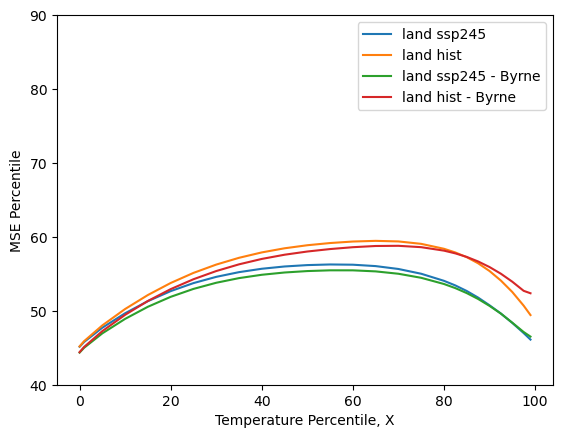

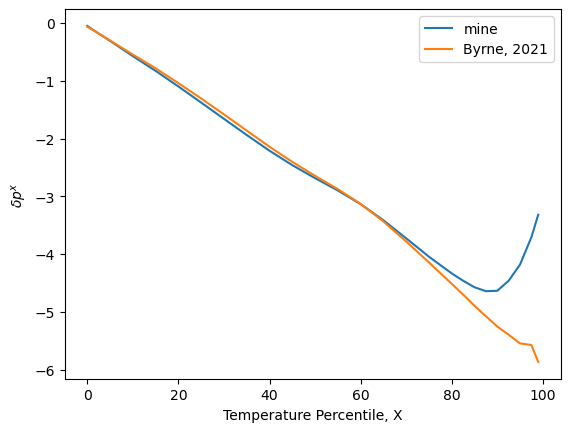

In [5]:
ds = xr.Dataset({})
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

for model in modelNames.ModelName:
    new = xr.open_dataset(f'px_ssp245_{model}.nc')
    new = new.drop_vars('time', errors = 'ignore')
    new = new.drop_vars('height', errors = 'ignore')
    new['MSE_land_px_mean'] = new.MSE_land_px.weighted(new.landFracWeight * new.latWeight).mean('lat')
    ds = xr.merge([ds, new.MSE_land_px_mean])
    new.close()

    
plt.plot(ds.MOP, ds.MSE_land_px_mean.mean('model'), label ='land ssp245')
ds_ssp245 = ds
ds = xr.Dataset({})
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

for model in modelNames.ModelName:
    new = xr.open_dataset(f'px_hist_{model}.nc')
    new = new.drop_vars('time', errors = 'ignore')
    new = new.drop_vars('height', errors = 'ignore')
    new['MSE_land_px_mean'] = new.MSE_land_px.weighted(new.landFracWeight * new.latWeight).mean('lat')
    ds = xr.merge([ds, new.MSE_land_px_mean])
    new.close()
ds_hist = ds

plt.plot(ds.MOP, ds.MSE_land_px_mean.mean('model'), label = 'land hist')


df = pd.read_csv('41561_2021_828_MOESM7_ESM.csv')
plt.plot(df['# X data'], df['Y data (dashed red line)'], label = 'land ssp245 - Byrne')
plt.plot(df['# X data'], df['Y data (solid red line)'], label = 'land hist - Byrne')
plt.xlabel('Temperature Percentile, X')
plt.ylabel('MSE Percentile')
plt.ylim([40,90])
plt.legend()
plt.show()

plt.plot(ds.MOP, ds_ssp245.MSE_land_px_mean.mean('model') - ds_hist.MSE_land_px_mean.mean('model'), label = 'mine')
plt.plot(df['# X data'], df['Y data (dashed red line)'] - df['Y data (solid red line)'],  label = 'Byrne, 2001')
plt.xlabel('Temperature Percentile, X')
plt.ylabel('$\delta p^x$')
plt.legend()
plt.show()



ACCESS-CM2: persons: PearsonRResult(statistic=0.9181994456273967, pvalue=3.8825365315905875e-11)
ACCESS-ESM1-5: persons: PearsonRResult(statistic=0.7656928999399165, pvalue=5.15865351492657e-06)
BCC-CSM2-MR: persons: PearsonRResult(statistic=0.9963777547103384, pvalue=3.306839911021524e-27)
CanESM5: persons: PearsonRResult(statistic=0.60656388860883, pvalue=0.0010196510213014397)
CESM2-WACCM: persons: PearsonRResult(statistic=0.9926256703720225, pvalue=1.6445866812575618e-23)
CNRM-CM6-1: persons: PearsonRResult(statistic=0.680790219239808, pvalue=0.00012933325421223482)
CNRM-ESM2-1: persons: PearsonRResult(statistic=0.658687398703933, pvalue=0.0002534691935776415)
GFDL-CM4: persons: PearsonRResult(statistic=0.9873374093391888, pvalue=1.051831418691628e-20)
GFDL-ESM4: persons: PearsonRResult(statistic=0.9897492348051724, pvalue=8.435194503591829e-22)
HadGEM3-GC31-LL: persons: PearsonRResult(statistic=0.8165811908425364, pvalue=3.6281892494921967e-07)
INM-CM4-8: persons: PearsonRResult(s

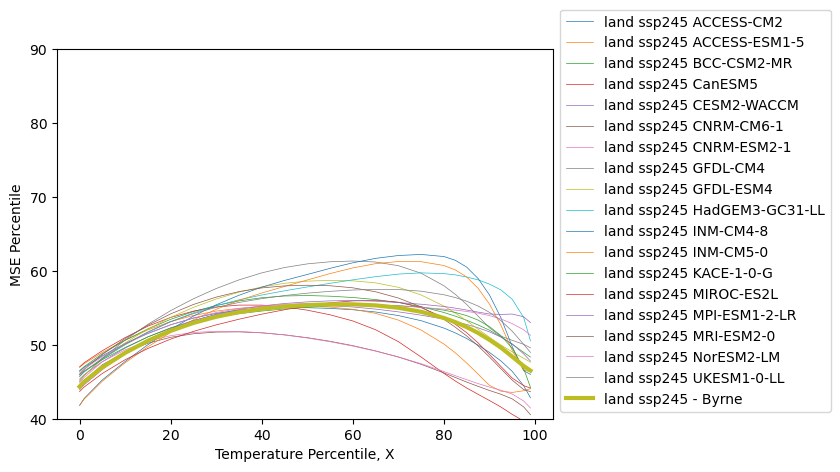

In [12]:
ds = xr.Dataset({})
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

for model in modelNames.ModelName:
    new = xr.open_dataset(f'px_ssp245_{model}.nc')
    new = new.drop_vars('time', errors = 'ignore')
    new = new.drop_vars('height', errors = 'ignore')
    new['MSE_land_px_mean'] = new.MSE_land_px.weighted(new.landFracWeight * new.latWeight).mean('lat')
    r = pearsonr(df['Y data (dashed red line)'], new.MSE_land_px_mean.isel(model = 0))
    print(f'{model}: persons: {r}')
    
    
    plt.plot(new.MOP, new.MSE_land_px_mean.isel(model = 0), label =f'land ssp245 {model}', linewidth = 0.5)
    new.close()


# for model in modelNames.ModelName:
#     new = xr.open_dataset(f'px_hist_{model}.nc')
#     new = new.drop_vars('time', errors = 'ignore')
#     new = new.drop_vars('height', errors = 'ignore')
#     new['MSE_land_px_mean'] = new.MSE_land_px.weighted(new.landFracWeight * new.latWeight).mean('lat')
#     plt.plot(new.MOP, new.MSE_land_px_mean.isel(model = 0), label =f'land hist {model}', linewidth = 1)
#     new.close()



df = pd.read_csv('41561_2021_828_MOESM7_ESM.csv')
plt.plot(df['# X data'], df['Y data (dashed red line)'], label = 'land ssp245 - Byrne', lw = 3)
# plt.plot(df['# X data'], df['Y data (solid red line)'], label = 'land hist - Byrne')
plt.xlabel('Temperature Percentile, X')
plt.ylabel('MSE Percentile')
plt.ylim([40,90])
plt.legend(loc = 3, bbox_to_anchor = (1, 0))
plt.show()

ACCESS-CM2: persons: PearsonRResult(statistic=0.9269299573869747, pvalue=1.04913052661922e-11)
ACCESS-ESM1-5: persons: PearsonRResult(statistic=0.7843450126319164, pvalue=2.1170931606767537e-06)
BCC-CSM2-MR: persons: PearsonRResult(statistic=0.9980371447558585, pvalue=2.1379687897300413e-30)
CanESM5: persons: PearsonRResult(statistic=0.5479449515110297, pvalue=0.003757918313322563)
CESM2-WACCM: persons: PearsonRResult(statistic=0.9821707024305808, pvalue=6.220400084644131e-19)
CNRM-CM6-1: persons: PearsonRResult(statistic=0.4783481820065766, pvalue=0.013440523779868629)
CNRM-ESM2-1: persons: PearsonRResult(statistic=0.3975784244482728, pvalue=0.0442897960403828)
GFDL-CM4: persons: PearsonRResult(statistic=0.9663278295758633, pvalue=1.18068684401756e-15)
GFDL-ESM4: persons: PearsonRResult(statistic=0.94735401720702, pvalue=2.283663238616421e-13)
HadGEM3-GC31-LL: persons: PearsonRResult(statistic=0.9572451161605269, pvalue=1.97854850412619e-14)
INM-CM4-8: persons: PearsonRResult(statisti

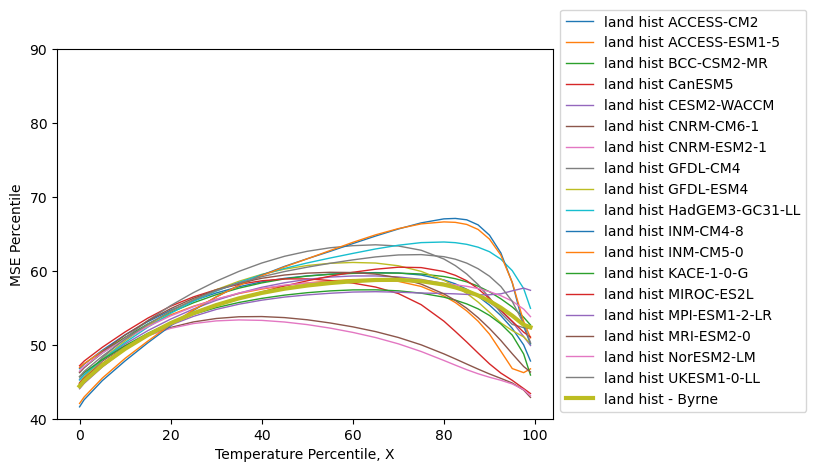

In [10]:
ds = xr.Dataset({})
df = pd.read_csv('41561_2021_828_MOESM7_ESM.csv')
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

# for model in modelNames.ModelName:
#     new = xr.open_dataset(f'px_ssp245_{model}.nc')
#     new = new.drop_vars('time', errors = 'ignore')
#     new = new.drop_vars('height', errors = 'ignore')
#     new['MSE_land_px_mean'] = new.MSE_land_px.weighted(new.landFracWeight * new.latWeight).mean('lat')
#     plt.plot(new.MOP, new.MSE_land_px_mean.isel(model = 0), label =f'land ssp245 {model}', linewidth = 0.5)
#     new.close()


for model in modelNames.ModelName:
    new = xr.open_dataset(f'px_hist_{model}.nc')
    new = new.drop_vars('time', errors = 'ignore')
    new = new.drop_vars('height', errors = 'ignore')
    new['MSE_land_px_mean'] = new.MSE_land_px.weighted(new.landFracWeight * new.latWeight).mean('lat')
    plt.plot(new.MOP, new.MSE_land_px_mean.isel(model = 0), label =f'land hist {model}', linewidth = 1)
    r = pearsonr(df['Y data (solid red line)'], new.MSE_land_px_mean.isel(model = 0))
    print(f'{model}: persons: {r}')
    new.close()



# plt.plot(df['# X data'], df['Y data (dashed red line)'], label = 'land ssp245 - Byrne', lw = 3)
plt.plot(df['# X data'], df['Y data (solid red line)'], label = 'land hist - Byrne', lw = 3)
plt.xlabel('Temperature Percentile, X')
plt.ylabel('MSE Percentile')
plt.ylim([40,90])
plt.legend(loc = 3, bbox_to_anchor = (1, 0))
plt.show()

In [17]:



def mean_above_percentiles(data, percentiles, axis):
    import xarray as xr
    import numpy as np
    # Calculate the threshold for each percentile
    thresholds = np.nanpercentile(data, percentiles, axis = axis )
    means = np.full_like(percentiles, np.nan, dtype=np.float64)  # Pre-allocate array for means

    # Calculate mean for values above each threshold
    for i, threshold in enumerate(thresholds):
        above_threshold = data[data > threshold]
        if above_threshold.size > 0:
            means[i] = np.nanmean(above_threshold)
            
    return means

def mean_above_percentiles_difVar(data, dataCon, percentiles, axis):
    import xarray as xr
    import numpy as np
    # Calculate the threshold for each percentile
    thresholds = np.nanpercentile(data, percentiles, axis=axis)
    means = np.full_like(percentiles, np.nan, dtype=np.float64)  # Pre-allocate array for means

    # Calculate mean for values above each threshold
    for i, threshold in enumerate(thresholds):
        above_threshold = dataCon[data > threshold]
        if above_threshold.size > 0:
            means[i] = np.nanmean(above_threshold)
            
    return means
    
def getMeansOverPercentile(da, percentiles, avgOut = ['time']):
    import xarray as xr
    import numpy as np
    import CMIPFuncs as func
    '''
    This function takes a dataset ds and a specific variable in it and for a list of percentiles finds the mean value of the data over a given percentile MOP for short 
    It defaults to taking in any ds and then reducing by time ie maintaining lat lon, and lev but if you wanted to get rid of those too you can change the average out function
    '''
    import xarray as xr
    import numpy as np
    import CMIPFuncs as func
    axis = np.arange(len(avgOut))
    da_new = xr.apply_ufunc(
    lambda x: mean_above_percentiles(x, percentiles, axis),  #add back func
        da,
        input_core_dims=[avgOut],
        output_core_dims=[["MOP"]],
        dask_gufunc_kwargs={
            'output_sizes': {"MOP": len(percentiles)},
            'allow_rechunk': True
        },
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
    )
    da_new = da_new.assign_coords(MOP=percentiles)
    return da_new

def getMeansOverPercentile_difVar(da, da_con, percentiles, avgOut = ['time']):
    '''
        the first specified variable is what it will use to find the percentile of and the second is the conVar which is the variable that we want the mean of 
    '''
    import xarray as xr
    import numpy as np
    import CMIPFuncs as func
    
    axis = np.arange(len(avgOut))
    
    da_new = xr.apply_ufunc(
    lambda x,y: mean_above_percentiles_difVar(x, y, percentiles, axis),  #add back func
    da, da_con,
    input_core_dims=[avgOut,avgOut],
    output_core_dims=[["MOP"]],
    dask_gufunc_kwargs={
        'output_sizes': {"MOP": len(percentiles)},
        'allow_rechunk': True
    },
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
    )
    da_new = da_new.assign_coords(MOP=percentiles)
    return da_new

---

In [35]:
## This gets the percentile of MSE in the historical simulation over land that corresponds to the mean MSE of land days where temperature exceeds the xth percentile
## This is a function of latitude and percentile
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import time
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
from scipy.stats import linregress, pearsonr
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
from multiprocessing import Pool, cpu_count
from scipy.stats import percentileofscore


for model in modelNames.ModelName:

    periods = ['historical']
    variables = ['tas', 'huss']
    percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
    
    print(f'{model} is starting...')
    tim = time.time()
    ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, periods)
    
    
    cp = 1004.6
    Lv = 2500000
    
    ds_hist['MSE'] = cp*ds_hist.tas + Lv*ds_hist.huss
    # ds_ssp245['MSE'] = cp*ds_ssp245.tas + Lv*ds_ssp245.huss
    
    
    # ds_hist['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 1), ds_hist.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    ds_hist['MSE_MOP_all'] = func.getMeansOverPercentile_difVar(ds_hist.tas, ds_hist.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    
    ### First two blocks here get the percentile of land moist static energy equal to the average moist static energy of days exceeding the xth percentile of landf temperature
    
    # ds_hist[f'MSE_land_px'] = xr.apply_ufunc(lambda x, y: percentileofscore(x.flatten(), y, nan_policy = 'omit'),
    #         ds_hist.MSE.where(ds_hist.landseamask == 1),
    #         ds_hist[f'MSE_MOP_land'],
    
        
    #         input_core_dims=[['time','lon'],[]],
    #         dask_gufunc_kwargs={
    #             'allow_rechunk': True
    #         },
    #     vectorize=True,
    #     dask="parallelized",
    #     output_dtypes=[float]
    #     )
    
    ds_hist[f'MSE_all_px'] = xr.apply_ufunc(lambda x, y: percentileofscore(x.flatten(), y, nan_policy = 'omit'),
            ds_hist.MSE.where(ds_hist.landseamask == 1),
            ds_hist[f'MSE_MOP_all'],
    
        
            input_core_dims=[['time','lon'],[]],
            dask_gufunc_kwargs={
                'allow_rechunk': True
            },
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
        )
    ds_hist = ds_hist.drop_vars(['tas', 'huss', 'MSE', 'lat_bnds', 'lon_bnds', 'time_bnds', 'landseamask'], errors='ignore')
    ds_hist.to_netcdf(f'px_hist_{model}_meth2.nc')
    

ACCESS-CM2 is starting...
ACCESS-ESM1-5 is starting...
BCC-CSM2-MR is starting...
CanESM5 is starting...
CESM2-WACCM is starting...


/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values

CNRM-CM6-1 is starting...
CNRM-ESM2-1 is starting...


KeyboardInterrupt: 

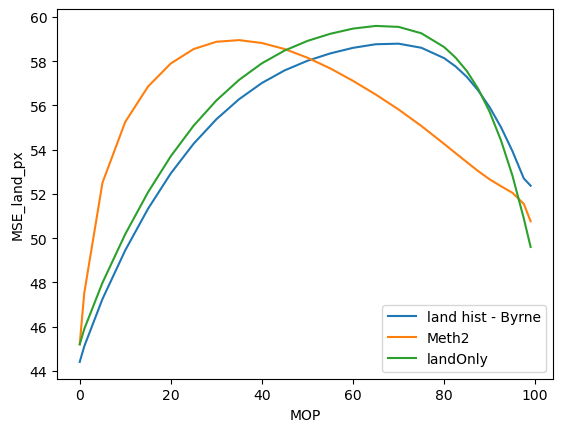

In [37]:
working = [0,1,2,3,4,5, 8, 9, 10, 11,12,13,14,15,16]


ds = xr.Dataset({})
df = pd.read_csv('41561_2021_828_MOESM7_ESM.csv')
plt.plot(df['# X data'], df['Y data (solid red line)'], label = 'land hist - Byrne')
for model in modelNames.ModelName[working]:
    new = xr.open_dataset(f'px_hist_{model}_meth2.nc')
    new = new.expand_dims(model = [model])
    new = new.drop_vars('height', errors = 'ignore')
    new = new.MSE_all_px.weighted(new.landFracWeight * new.latWeight).mean('lat')
    ds = xr.merge([ds, new])
ds.MSE_all_px.mean('model').plot(label = 'Meth2')

ds = xr.Dataset({})

for model in modelNames.ModelName[working]:
    new = xr.open_dataset(f'px_hist_{model}.nc')
    new = new.drop_vars('height', errors = 'ignore')
    new = new.MSE_land_px.weighted(new.landFracWeight * new.latWeight).mean('lat')
    ds = xr.merge([ds, new])
ds.MSE_land_px.mean('model').plot(label = 'landOnly')
plt.legend()



--- 
## testing to make sure means over percentiles works as intended


In [3]:
periods = ['historical', 'ssp245']
variables = ['tas', 'huss']
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
model = 'CanESM5'
print(f'{model} is starting...')
tim = time.time()
ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, periods)


cp = 1004.6
Lv = 2500000

ds_hist['MSE'] = cp*ds_hist.tas + Lv*ds_hist.huss
ds_ssp245['MSE'] = cp*ds_ssp245.tas + Lv*ds_ssp245.huss

ds_hist['tas_MOP_land'] = func.getMeansOverPercentile(ds_hist.tas.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
ds_hist['tas_MOP_ocean'] = func.getMeansOverPercentile(ds_hist.tas.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])

ds_ssp245['tas_MOP_land'] = func.getMeansOverPercentile(ds_ssp245.tas.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
ds_ssp245['tas_MOP_ocean'] = func.getMeansOverPercentile(ds_ssp245.tas.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])

ds_hist['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 1), ds_hist.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
ds_hist['MSE_MOP_ocean'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 0), ds_hist.MSE.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])

ds_ssp245['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_ssp245.tas.where(ds_hist.landseamask == 1), ds_ssp245.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
ds_ssp245['MSE_MOP_ocean'] = func.getMeansOverPercentile_difVar(ds_ssp245.tas.where(ds_hist.landseamask == 0), ds_ssp245.MSE.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])

### First two blocks here get the percentile of land moist static energy equal to the average moist static energy of days exceeding the xth percentile of landf temperature

ds_hist[f'MSE_land_px'] = xr.apply_ufunc(lambda x, y: percentileofscore(x.flatten(), y, nan_policy = 'omit'),
        ds_hist.MSE.where(ds_hist.landseamask == 1),
        ds_hist[f'MSE_MOP_land'],

    
        input_core_dims=[['time','lon'],[]],
        dask_gufunc_kwargs={
            'allow_rechunk': True
        },
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
    )

ds_ssp245[f'MSE_land_px'] = xr.apply_ufunc(lambda x, y: percentileofscore(x.flatten(), y, nan_policy = 'omit'),
        ds_ssp245.MSE.where(ds_ssp245.landseamask == 1),
        ds_hist[f'MSE_MOP_land'],

    
        input_core_dims=[['time','lon'],[]],
        dask_gufunc_kwargs={
            'allow_rechunk': True
        },
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
    )

CanESM5 is starting...


OSError: [Errno 116] Stale file handle: '/badc/cmip6/data/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/day/tas/gn/files/'

In [6]:
landMask = xr.open_dataset('/badc/cmip6/data/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp245/r1i1p1f1/fx/sftlf/gr1/latest/sftlf_fx_GFDL-CM4_ssp245_r1i1p1f1_gr1.nc').sftlf


/opt/jaspy/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/opt/jaspy/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/opt/jaspy/lib/python3.11/site-packages/xarray/backends/plugins.py:168: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/opt/jaspy/lib/python3.11/site-packages/xarray/backends/plugins.py:168: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/opt/jaspy/lib/python3.11/site-packages/xarray/backends/plugins.py:168: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'cfgrib', 'gini', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

[Errno 116] Stale file handle: '/badc/cmip5'
/home/users/chingosa/CMIP6


In [4]:
cd /badc/cmip6

[Errno 116] Stale file handle: '/badc/cmip6'
/home/users/chingosa/CMIP6


 13_11_24.ipynb
 41561_2021_828_MOESM10_ESM.csv
 41561_2021_828_MOESM4_ESM.csv
 41561_2021_828_MOESM7_ESM.csv
'Additional Workspace.ipynb'
 AlphaCalculations.ipynb
 CMIP6Models.xlsx
 CMIP6_Explore.ipynb
 Fixed_RH_Theory_ACCESS-CM2.csv
 Fixed_RH_Theory_ACCESS-CM2_mal.csv
 Fixed_RH_Theory_ACCESS-CM2_msam.csv
 Fixed_RH_Theory_ACCESS-ESM1-5.csv
 Fixed_RH_Theory_ACCESS-ESM1-5_mal.csv
 Fixed_RH_Theory_ACCESS-ESM1-5_msam.csv
 Fixed_RH_Theory_All.csv
 Fixed_RH_Theory_All_mal.csv
 Fixed_RH_Theory_All_msam.csv
 Fixed_RH_Theory_BCC-CSM2-MR.csv
 Fixed_RH_Theory_BCC-CSM2-MR_mal.csv
 Fixed_RH_Theory_BCC-CSM2-MR_msam.csv
 Fixed_RH_Theory_CESM2-WACCM.csv
 Fixed_RH_Theory_CESM2-WACCM_mal.csv
 Fixed_RH_Theory_CESM2-WACCM_msam.csv
 Fixed_RH_Theory_CNRM-CM6-1.csv
 Fixed_RH_Theory_CNRM-CM6-1_mal.csv
 Fixed_RH_Theory_CNRM-CM6-1_msam.csv
 Fixed_RH_Theory_CNRM-ESM2-1.csv
 Fixed_RH_Theory_CNRM-ESM2-1_mal.csv
 Fixed_RH_Theory_CNRM-ESM2-1_msam.csv
 Fixed_RH_Theory_CanESM5.csv
 Fixed_RH_Theory_CanESM5_mal.csv
 Fi